In [1]:
import time
import numpy as np
import joblib
import pandas as pd
import seaborn as sb
import truvari
import matplotlib.pyplot as plt
sb.set()
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
def show_values_on_bars(axs, fmt='{:.2f}', buff=0, box=True, size=15):
    """ 
        Given a barchart (seaborn or matplotlib), add values on top of bars
         c/o https://stackoverflow.com/a/51535326 
    """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + buff
            value = fmt.format(p.get_height())
            t = ax.text(_x, _y, value, ha="center", size=size)
            if box:
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
features = ['VARLEN', 'GT', 'GQ', 'DP', 'AD_r', 'AD_a', 'US_r', 'US_a', 
            'DS_r', 'DS_a', 'UC_r', 'UC_a', 'DC_r', 'DC_a', 'UDC_r', 
            'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 'DCC_a', 
            'UMO_r', 'UMO_a', 'DMO_r', 'DMO_a', 'NR_r', 'NR_a', 'MO_r', 'MO_a', 
            'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 'EC_r', 'EC_a', 
            'PL_ref', 'PL_het', 'PL_hom',
            'UXO_r', 'UXO_a', 'DXO_r', 'DXO_a', 'XO_r', 'XO_a']
trans_features = ["AD_r", "AD_a", "UC_r", "UC_a", "DC_a", "DC_r", 'UDC_r', 'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 'DCC_a', 'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 'EC_r', 'EC_a']
keep_features = [_ for _ in features if _ not in trans_features] + ["RC"]
labels = ["GT_answer"]

# I want to see what happens when I transform the _r / _a numbers into all ratios of one another
def transform(data):
    ret = pd.DataFrame()
    union = set()
    others = []
    for i in trans_features:
        if i.endswith('_r') or i.endswith("_a"):
            union.add(i.split('_')[0])
        else:
            ret[i] = data[i]
    for i in union:
        denom = data[i + '_a'] + data[i + '_r']
        alt = data[i + '_a'] / denom
        ref = data[i + '_r'] / denom
        ret[i] = alt - ref
    for i in keep_features:
        ret[i] = data[i]
    # No coverage is assumed to be -1
    to_return = norm_rl(ret.fillna(-1))
    return to_return

def norm_rl(df):
    """
    Normalizes read length dependent features
    """
    rl_feat = ["US_r", "US_a", "DS_a", "DS_r", "UXO_r", "UXO_a", "DXO_r", "DXO_a", "UMO_r", "UMO_a", "DMO_r", "DMO_a", "MO_r", "MO_a", "XO_r", "XO_a"]
    rl = df['MO_r'].max()
    df[rl_feat] = df[rl_feat] / rl
    return df

def set_size(x):
    # SET VARLEN to the appropriate sign
    return x["VARLEN"] if x["var_type"] == "INS" else -x["VARLEN"]

def norm_nr(line):
    if line["VARLEN"] < 0:
        line["NR_r"] = line["NR_r"] / abs(line["VARLEN"])
    else:
        line["NR_a"] = line["NR_a"] / line["VARLEN"]
    return line

In [203]:
def make_dataframe(base_variants, coverage_df, no_neigh=True):
    """
    Given a vcf, the base variants overwhich we're training, and the coverage df
    Build the full data-frame with their correct label
    If no_neigh, only return rows without neighbors
    returns dataframe
    """
    base = joblib.load(base_variants)
    cov_df = joblib.load(coverage_df)
    cov_df = cov_df.set_index("key")
    
    if no_neigh:
        cnt = len(base)
        base = base[base["NumNeighbors"] == 0]
        removed = cnt - len(base)
        rm_pct = removed / cnt * 100
        print(f"Removed {removed:,} of {cnt:,} ({rm_pct:.1f}%) sites with >= 1 Neighs. {len(base):,} Remaining.")
    data = cov_df.loc[cov_df.index.isin(base.index)]
    labels = base["GT"].apply(lambda x: truvari.get_gt(x).value)
    data = data.join(labels, rsuffix="_label")
    data = data.join(base["NumNeighbors"])
    return data

def make_paragraph_results(base, comp):
    """
    Returns results and full from a join/anno of the base/comparison SV vcfs.jl
    """
    par_base = joblib.load(base)
    par_comp = joblib.load(comp)
    par_full = par_base.join(par_comp, lsuffix="_base", rsuffix="_comp")
    par_full["GT_base"] = par_full["GT_base"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    par_full["GT_comp"] = par_full["GT_comp"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    par_full["concordant"] = par_full["GT_comp"] == par_full["GT_base"]
    par_full["GQ"] = par_full[["PL_ref", "PL_het", "PL_hom"]].max(axis=1)
    par_test = par_full[["GQ", "GT_comp", "GT_base", "concordant", "DP", "svtype_base", "PL_ref", "PL_het", "PL_hom", "NumNeighbors"]]
    par_test.columns = ["GQ", "predict", "GT_label", "concordant", "DP", "svtype", "REF", "HET", "HOM", "NumNeighbors"]
    par_test = par_test.dropna()
    par_test["predict"] = par_test["predict"].astype(int)
    par_test["presence"] = par_test[["GT_label", "predict"]].apply(presence_compare, axis=1)
    return par_test, par_full

def make_flatvcf_results(base, comp):
    """
    Returns results and full from a join/anno of the base/comparison SV vcfs.jl
    """
    base = joblib.load(base)
    comp = joblib.load(comp)
    full = base.join(comp, lsuffix="_base", rsuffix="_comp")
    full["GT_base"] = full["GT_base"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    full["GT_comp"] = full["GT_comp"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    full["concordant"] = full["GT_comp"] == full["GT_base"]
    res = full[["GQ", "GT_comp", "GT_base", "concordant", "DP", "svtype_base", "PL_ref", "PL_het", "PL_hom", "NumNeighbors"]]
    res.columns = ["GQ", "predict", "GT_label", "concordant", "DP", "svtype", "REF", "HET", "HOM", "NumNeighbors"]
    res = res.dropna()
    res["predict"] = res["predict"].astype(int)
    res["presence"] = res[["GT_label", "predict"]].apply(presence_compare, axis=1)
    return res, full

def rank_feature_importance(forest, features):
    """
    Given a created classifier pipeline (where step[1] is the RFC), and the feature names
    make a plot of the feature importance based on mean decrease in impurity
    """
    start_time = time.time()
    clsf = forest.steps[1][1]
    importances = clsf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clsf.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=features)
    forest_importances.sort_values(inplace=True, ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def build_model(data, label):
    """
    Build and return pipeline with StandardScaler and RFC
    transform(keep, trans_features, keep_features), answer
    """
    rfc = RandomForestClassifier(random_state=1392,
                                 n_jobs=-1, n_estimators=500,
                                 bootstrap=True, max_features="sqrt", 
                                 max_depth=30)
    svc = SVC(gamma='auto', probability=True)
    lrg = LogisticRegression(max_iter=500)
    clf = make_pipeline(StandardScaler(), rfc)
    return clf.fit(data, label)

def run_model(model, data):
    t_data = transform(data)
    gts = pd.Series(model.predict(t_data), name="predict")#.apply(lambda x: truvari.GT(x).name)
    pls = pd.DataFrame(model.predict_proba(t_data), columns=["REF", "HET", "HOM"])
    def rounder(d):
        r = -10 * np.log10(d)
        r = r.replace(-0, 0).replace([np.inf], 99).round().astype(int)
        return r
    pls['PL_ref'] = rounder(pls["REF"])
    pls['PL_het'] = rounder(pls['HET'])
    pls['PL_hom'] = rounder(pls['HOM'])
    pls["GQ"] = pls[["PL_ref", "PL_het", "PL_hom"]].min(axis=1)
    ret = pls.join(gts)
    ret.index = t_data.index
    #.apply(lambda x: truvari.GT(x).name))#test_base["GT"])
    return ret.join(data["GT_label"])

def make_roc_curves(results, title_label):
    """
    """
    for tys, label in [(["DEL", "INS"], "TOT"), (["INS"], "INS"), (["DEL"], "DEL")]:
        res = results[results["svtype"].isin(tys)]
        fpr, tpr, thresholds = roc_curve(res["concordant"], res[["REF", "HET", "HOM"]].max(axis=1))
        auc = roc_auc_score(res["concordant"], res[["REF", "HET", "HOM"]].max(axis=1))
        accuracy = res["concordant"].mean()
        plt.plot(fpr, tpr, label="%s (%.2f%%, %.2f)" % (label, accuracy * 100, auc))
    plt.title(f"{title_label} ROC curves")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(title="SV (ACC, AUC)")
    hide = plt.show()

def summarize_perf_by_attribs(results):
    rows = []
    for vals, dat in results.groupby(["svtype", "GT_label"]):
        dat = dat.groupby(["concordant"]).count()
        tp = dat.loc[True]["REF"]
        fp = dat.loc[False]["REF"]
        rows.append([vals[0], truvari.GT(vals[1]).name, tp / (tp + fp)])
    summary = pd.DataFrame(rows, columns=["svtype", "GT", "pct_correct"])

    p = sb.barplot(data=summary, x="GT", y="pct_correct", hue="svtype")
    p.set(title="Performance by Type/GT", ylim=(0,1.1), xlabel="Label GT")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    show_values_on_bars(p, box=False)
    plt.show()
    return summary

def make_gt_heatmap(results):
    rows = np.zeros((3,3))
    for label, dat in results.groupby(["GT_label", "predict"]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        if label[0] >= 3 or label[1] >= 3:
            continue
        cnt = len(dat)
        rows[label[0]][label[1]] = cnt
    rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
    pred_rows = rows / rows.sum(axis=0)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    label_rows = rows.T / rows.sum(axis=1)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    
def presence_compare(vals):
    base, comp = vals.to_list()
    if base == 0:
        if comp == 0:
            return "TN"
        else:
            return "FP"
    else:
        if comp == 0:
            return "FN"
        else:
            return "TP"

def presence_performance(m_data):
    counts = m_data["presence"].value_counts()
    tp = counts["TP"] if "TP" in counts else 0
    fp = counts["FP"] if "FP" in counts else 0
    tn = counts["TN"] if "TN" in counts else 0
    fn = counts["FN"] if "FN" in counts else 0
    try:
        tpr = tp / (tp + fn)
    except Exception:
        tpr = None
    try:
        tnr = tn / (tn + fp)
    except Exception:
        tnr = None
    try:
        ppv = tp / (tp + fp)
    except Exception:
        ppv = None
    try:
        npv = tn / (tn + fn)
    except Exception:
        npv = None
    try:
        fpr = fp / (fp + tn)
    except Exception:
        fpr = None
    try:
        acc = (tp + tn) / counts.sum()
    except Exception:
        acc = None
    try:
        fdr = fp / (fp + tp)
    except Exception:
        fdr = None
    return pd.DataFrame([{"TPR": tpr, "FPR": fpr, "FDR": fdr, "ACC": acc, "TNR": tnr, "PPV": ppv, "NPV": npv}])

def predict_gt(m_data, model):
    # Predict the GT for the test data and fill in extra annotation
    results = run_model(model, m_data)
    results["concordant"] = results["predict"] == results["GT_label"]
    results["presence"] = results[["GT_label", "predict"]].apply(presence_compare, axis=1)
    svtype = m_data["var_type"]
    svtype.name = "svtype"
    results = results.join(svtype)
    results = results.join(m_data["DP"])
    results = results.join(m_data["NumNeighbors"])
    return results

def accuracy_report(results):
    print(len(results), "SVs to report")
    print("Overall Accuracy:", results["concordant"].mean())
    print(results.groupby(["GT_label"])["concordant"].mean())

    make_roc_curves(results, "Overall")
    make_roc_curves(results[results["GT_label"] != 0], "Present SVs")
    make_roc_curves(results[results["GT_label"] == 0], "Reference SVs")

    summary = summarize_perf_by_attribs(results)
    print(summary)

    make_gt_heatmap(results)
    print("Presence Performance Overall")
    print(presence_performance(results))

In [58]:
train_data1 = make_dataframe("/home/english/science/english/msru/data/gt_training/HG00096.base.jl",
                             "/home/english/science/english/msru/data/gt_training/HG00096.cov.jl")
train_data2 = make_dataframe("/home/english/science/english/msru/data/gt_training/NA20847.base.jl",
                             "/home/english/science/english/msru/data/gt_training/NA20847.cov.jl")
train_data3 = make_dataframe("/home/english/science/english/msru/data/gt_training/HG01505.base.jl",
                             "/home/english/science/english/msru/data/gt_training/HG01505.cov.jl")
train_data = pd.concat([train_data1, train_data2, train_data3])

Removed 29,539 of 48,795 (60.5%) sites with >= 1 Neighs. 19,256 Remaining.
Removed 29,539 of 48,795 (60.5%) sites with >= 1 Neighs. 19,256 Remaining.
Removed 29,539 of 48,795 (60.5%) sites with >= 1 Neighs. 19,256 Remaining.


In [121]:
train_data = pd.concat([train_data1, train_data2, train_data3])

In [122]:
print("Training Label Freq")
train_data["GT_label"].apply(truvari.GT).value_counts()

Training Label Freq


GT.REF    23035
GT.HET    20987
GT.HOM    13689
Name: GT_label, dtype: int64

In [123]:
suf_cov = (train_data["DP"] >= 10) & (train_data["DP"] <= 100)
train_data[suf_cov]["GT_label"].apply(truvari.GT).value_counts()

GT.REF    19389
GT.HET    18399
GT.HOM    11835
Name: GT_label, dtype: int64

In [124]:
sub = train_data[suf_cov].sample(frac=.75, random_state=192)
sub["GT_label"].apply(truvari.GT).value_counts()

GT.REF    14520
GT.HET    13799
GT.HOM     8898
Name: GT_label, dtype: int64

In [125]:
model = build_model(transform(train_data), train_data["GT_label"])

Elapsed time to compute the importances: 0.643 seconds


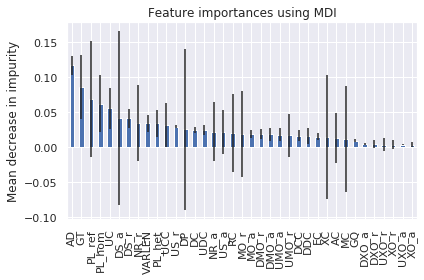

In [126]:
rank_feature_importance(model, transform(train_data).columns)

In [117]:
test_data = make_dataframe("/home/english/science/english/msru/data/gt_training/grch38.HG03125.base.jl",
                           "/home/english/science/english/msru/data/gt_training/grch38.HG03125.cov.jl",
                            no_neigh=False)

In [127]:
results = predict_gt(test_data, model)

/raid/home/english/pyve/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [181]:
p_results, p_data = make_paragraph_results("/home/english/science/english/msru/data/gt_training/paragraph/HG03125.base.jl",
                                           "/home/english/science/english/msru/data/gt_training/paragraph/HG03125.comp.jl")

In [189]:
a = presence_performance(results)
a["Method"] = "BioGraph"
a["Neigh"] = True
b = presence_performance(results[results["NumNeighbors"] == 0])
b["Method"] = "BioGraph"
b["Neigh"] = False
c = presence_performance(p_results)
c["Method"] = "Paragraph"
c["Neigh"] = True
d = presence_performance(p_results[p_results["NumNeighbors"] == 0])
d["Method"] = "Paragraph"
d["Neigh"] = False
pd.concat([a, b, c, d])

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,Method,Neigh
0,0.677934,0.111188,0.475413,0.856497,0.888812,0.524587,0.938459,BioGraph,True
0,0.915775,0.046374,0.143487,0.944840,0.953626,0.856513,0.973997,BioGraph,False
0,0.904895,0.580895,0.783906,0.492145,0.419105,0.216094,0.961394,Paragraph,True
0,0.934423,0.122758,0.285498,0.891390,0.877242,0.714502,0.976012,Paragraph,False


144791 SVs to report
Overall Accuracy: 0.8418824374443163
GT_label
0    0.888812
1    0.555324
2    0.678710
Name: concordant, dtype: float64


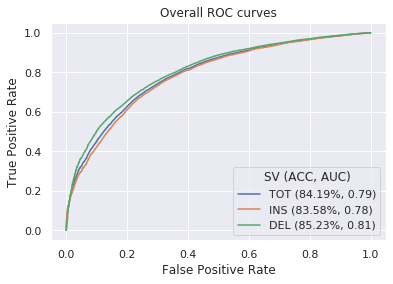

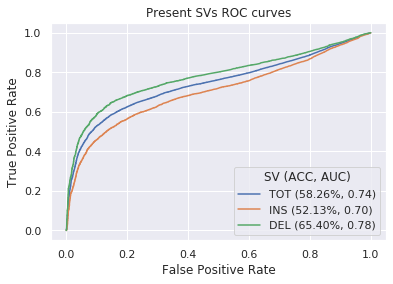

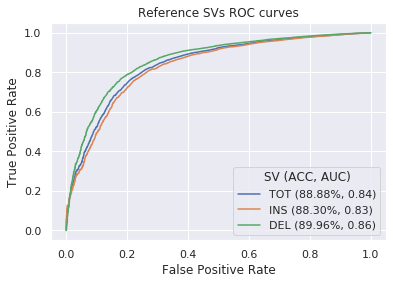

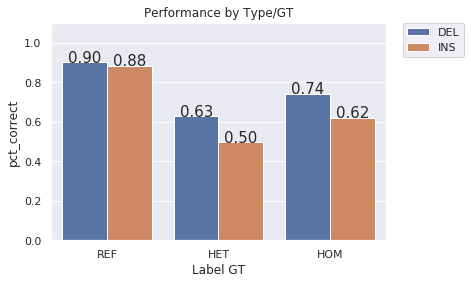

  svtype   GT  pct_correct
0    DEL  REF     0.899620
1    DEL  HET     0.627476
2    DEL  HOM     0.739579
3    INS  REF     0.882989
4    INS  HET     0.495668
5    INS  HOM     0.619144


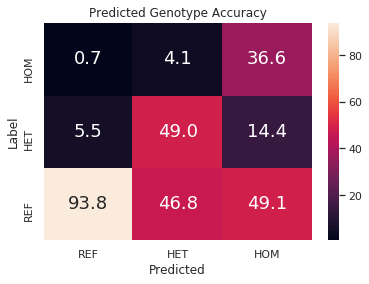

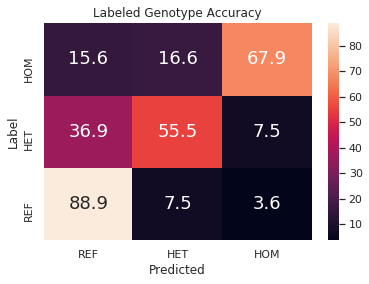

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV
0  0.677934  0.111188  0.475413  0.856497  0.888812  0.524587  0.938459


In [193]:
accuracy_report(results)

33811 SVs to report
Overall Accuracy: 0.9357901274733075
GT_label
0    0.953626
1    0.866475
2    0.897087
Name: concordant, dtype: float64


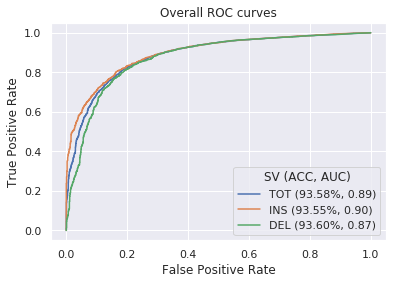

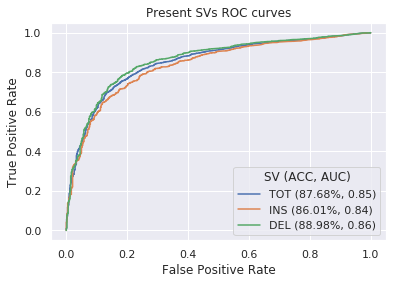

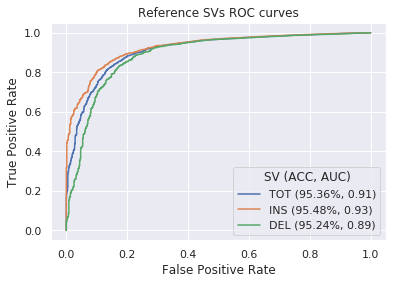

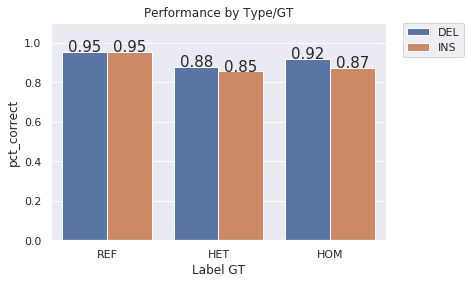

  svtype   GT  pct_correct
0    DEL  REF     0.952408
1    DEL  HET     0.875974
2    DEL  HOM     0.917808
3    INS  REF     0.954751
4    INS  HET     0.854037
5    INS  HOM     0.871513


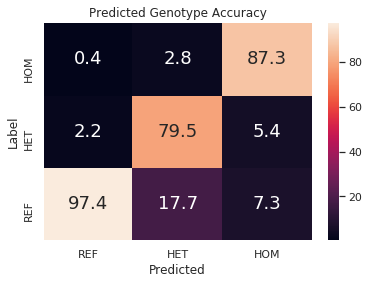

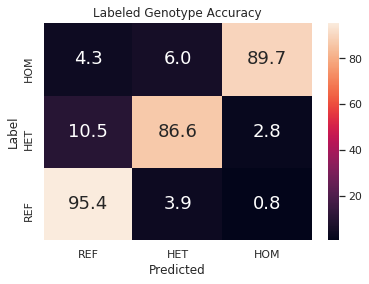

Presence Performance Overall
        TPR       FPR       FDR      ACC       TNR       PPV       NPV
0  0.915775  0.046374  0.143487  0.94484  0.953626  0.856513  0.973997


In [195]:
accuracy_report(results[results["NumNeighbors"] == 0])

33811 SVs to report
Overall Accuracy: 0.9357901274733075
GT_label
0    0.953626
1    0.866475
2    0.897087
Name: concordant, dtype: float64


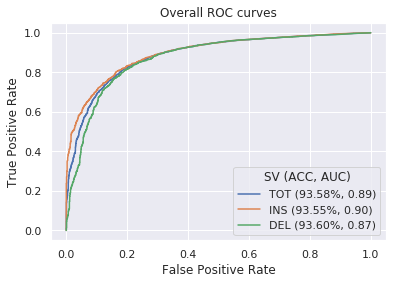

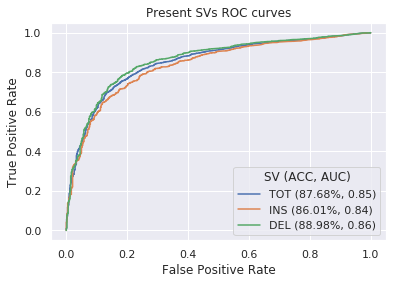

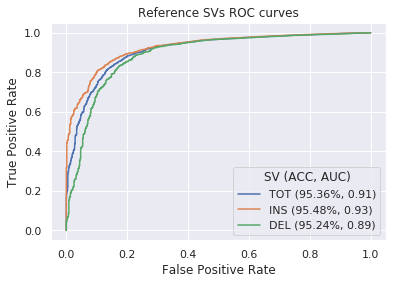

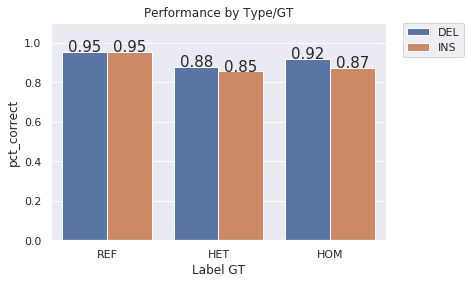

  svtype   GT  pct_correct
0    DEL  REF     0.952408
1    DEL  HET     0.875974
2    DEL  HOM     0.917808
3    INS  REF     0.954751
4    INS  HET     0.854037
5    INS  HOM     0.871513


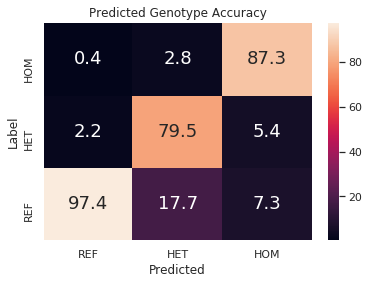

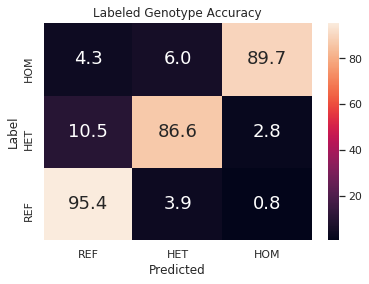

Presence Performance Overall
        TPR       FPR       FDR      ACC       TNR       PPV       NPV
0  0.915775  0.046374  0.143487  0.94484  0.953626  0.856513  0.973997
Presence Performance Non-Ref
        TPR   FPR  FDR       ACC   TNR  PPV  NPV
0  0.915775  None  0.0  0.915775  None  1.0  0.0
percent of sites with no neighbors: 0.23351589532498568


In [129]:
no_neigh = results["NumNeighbors"] == 0
accuracy_report(results[no_neigh])
print("percent of sites with no neighbors:", len(results[no_neigh]) / len(results))

percent of sites with no_neigh and sufficent coverage: 0.20386626240581252
29518 SVs to report
Overall Accuracy: 0.9518937597398198
GT_label
0    0.967223
1    0.893757
2    0.921577
Name: concordant, dtype: float64


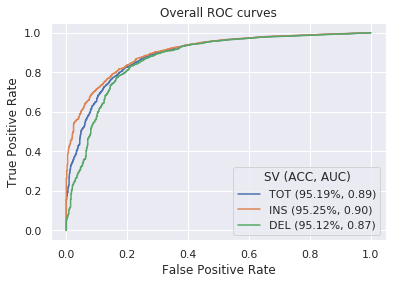

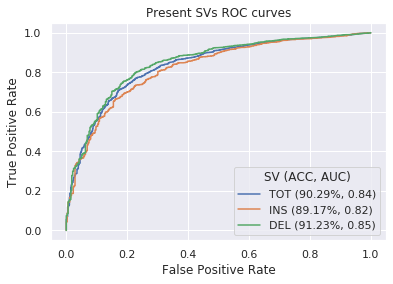

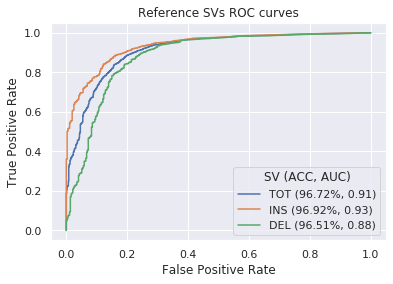

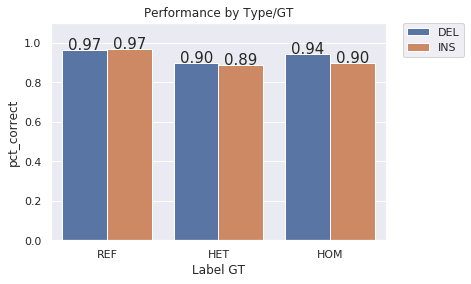

  svtype   GT  pct_correct
0    DEL  REF     0.965073
1    DEL  HET     0.897740
2    DEL  HOM     0.944120
3    INS  REF     0.969177
4    INS  HET     0.888836
5    INS  HOM     0.897205


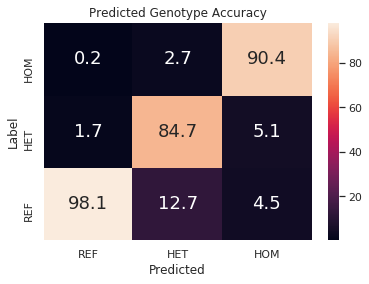

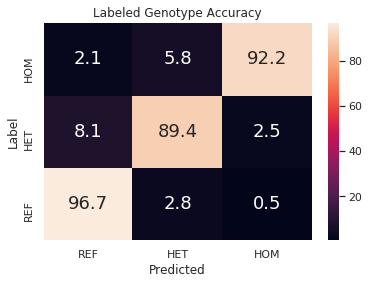

Presence Performance Overall
       TPR       FPR       FDR       ACC       TNR       PPV       NPV
0  0.93886  0.032777  0.100409  0.960465  0.967223  0.899591  0.980611
Presence Performance Non-Ref
       TPR   FPR  FDR      ACC   TNR  PPV  NPV
0  0.93886  None  0.0  0.93886  None  1.0  0.0


In [130]:
# Only analyze sites that have sufficient depth
has_cov = (results["DP"] >= 10) & (results["DP"] <= 100)
print("percent of sites with no_neigh and sufficent coverage:", len(results[no_neigh & has_cov]) / len(results))
accuracy_report(results[no_neigh & has_cov])

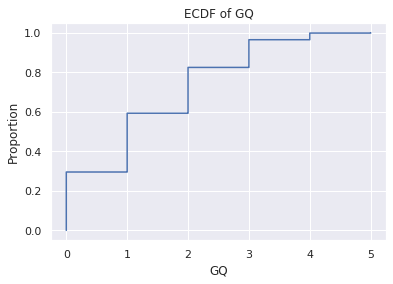

In [131]:
p = sb.ecdfplot(results["GQ"])
plt.xticks(range(0, results["GQ"].max() + 1))
hide = p.set(title="ECDF of GQ")

percent of sites with no_neigh, sufficent coverage and high confidence 0.2030996401710051
29407 SVs to report
Overall Accuracy: 0.9537185023973884
GT_label
0    0.968606
1    0.893920
2    0.930641
Name: concordant, dtype: float64


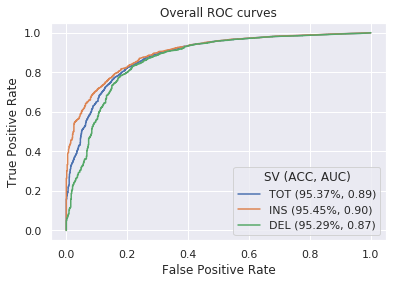

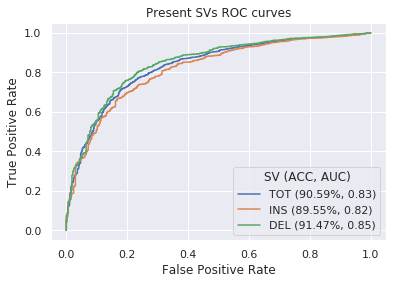

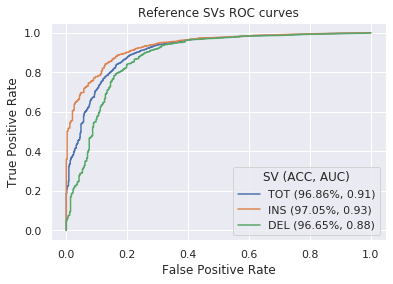

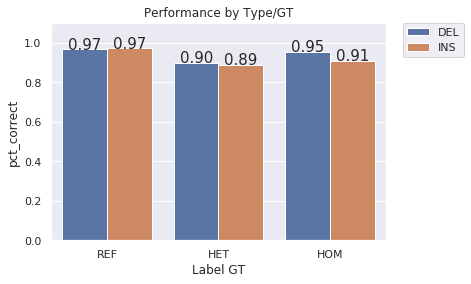

  svtype   GT  pct_correct
0    DEL  REF     0.966479
1    DEL  HET     0.897653
2    DEL  HOM     0.951939
3    INS  REF     0.970541
4    INS  HET     0.889311
5    INS  HOM     0.907509


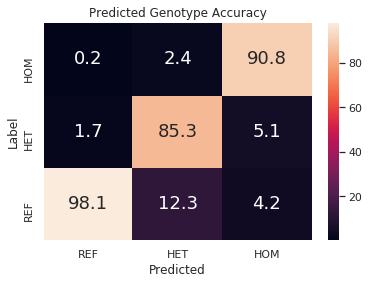

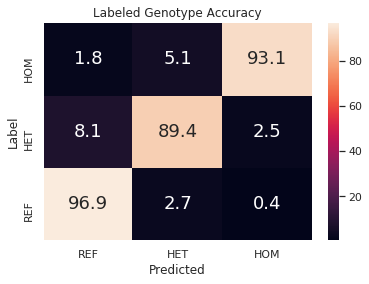

Presence Performance Overall
        TPR       FPR       FDR      ACC       TNR       PPV       NPV
0  0.939559  0.031394  0.096916  0.96171  0.968606  0.903084  0.980942
Presence Performance Non-Ref
        TPR   FPR  FDR       ACC   TNR  PPV  NPV
0  0.939559  None  0.0  0.939559  None  1.0  0.0


In [132]:
# Only analyze sites that have sufficient depth and a very confident predicted genotype
high_conf = results["GQ"] <= 3
print("percent of sites with no_neigh, sufficent coverage and high confidence", len(results[no_neigh & has_cov & high_conf]) / len(results))
accuracy_report(results[no_neigh & has_cov & high_conf])

# Comparing against old model

12357 SVs to report
Overall Accuracy: 0.8983572064416929
GT_label
0    0.991874
1    0.234783
2    0.423154
Name: concordant, dtype: float64


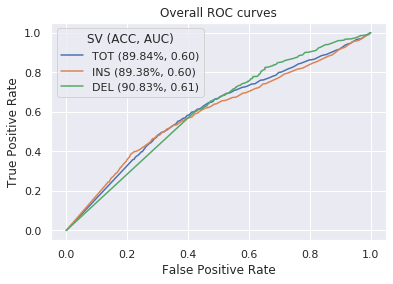

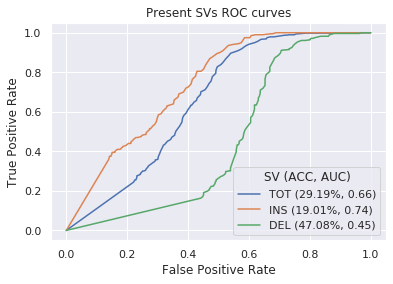

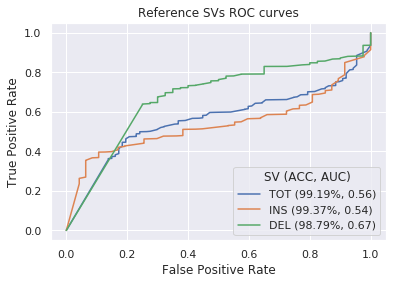

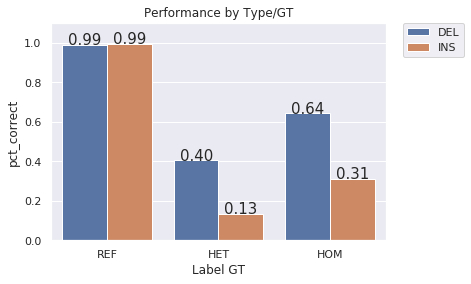

  svtype   GT  pct_correct
0    DEL  REF     0.987860
1    DEL  HET     0.403712
2    DEL  HOM     0.642857
3    INS  REF     0.993658
4    INS  HET     0.133519
5    INS  HOM     0.312312


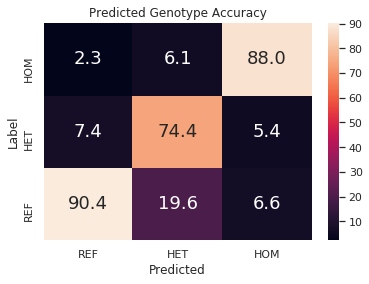

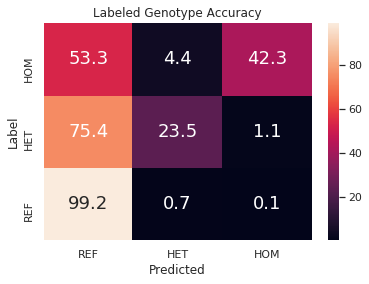

Presence Performance Overall
        TPR       FPR      FDR      ACC       TNR      PPV       NPV
0  0.313144  0.008126  0.14404  0.90119  0.991874  0.85596  0.903514
Presence Performance Non-Ref
        TPR   FPR  FDR       ACC   TNR  PPV  NPV
0  0.313144  None  0.0  0.313144  None  1.0  0.0


In [36]:
accuracy_report(new)

2979 SVs to report
Overall Accuracy: 0.9167505874454515
GT_label
0    0.986760
1    0.572368
2    0.666667
Name: concordant, dtype: float64


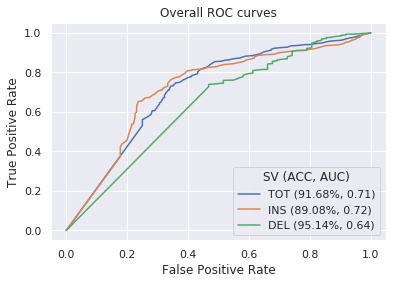

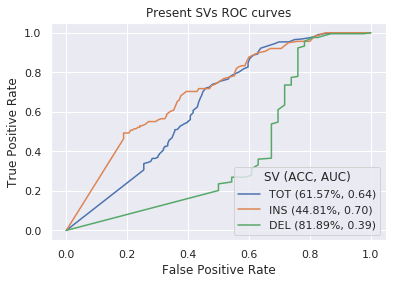

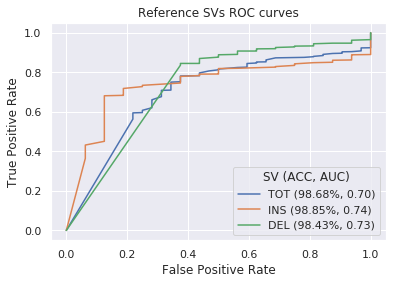

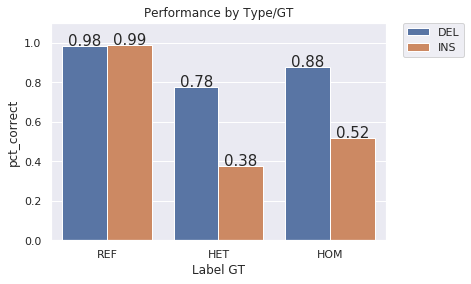

  svtype   GT  pct_correct
0    DEL  REF     0.984329
1    DEL  HET     0.777027
2    DEL  HOM     0.877358
3    INS  REF     0.988539
4    INS  HET     0.378205
5    INS  HOM     0.519737


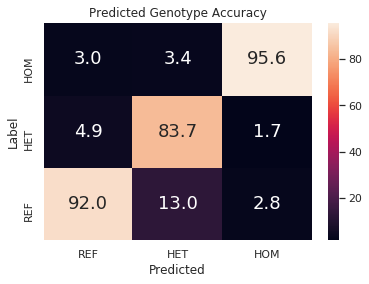

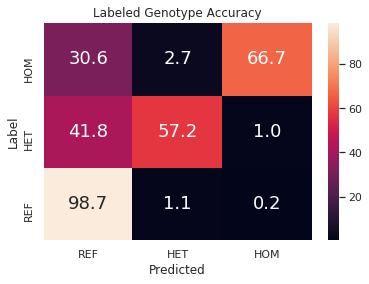

Presence Performance Overall
        TPR      FPR       FDR       ACC      TNR       PPV       NPV
0  0.633452  0.01324  0.082474  0.920107  0.98676  0.917526  0.920494
Presence Performance Non-Ref
        TPR   FPR  FDR       ACC   TNR  PPV  NPV
0  0.633452  None  0.0  0.633452  None  1.0  0.0


In [37]:
# Only analyze sites that have sufficient depth and a very confident predicted genotype
no_neigh = new["NumNeighbors"] == 0
accuracy_report(new[no_neigh])

In [24]:
presence_performance(results[no_neigh & has_cov]["presence"].value_counts())

/raid/home/english/pyve/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.961722,0.075829,0.038278,0.949126,0.924171,0.961722,0.924171


In [25]:
presence_performance(results[results["GT_label"] != 0]["presence"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.772022,None,0.0,0.772022,None,1.0,0.0


In [198]:
results.GT_label.value_counts() / len(results)

0    0.846758
1    0.119407
2    0.033835
Name: GT_label, dtype: float64

192246 SVs to report
Overall Accuracy: 0.4567637298045213
GT_label
0    0.419105
1    0.637869
2    0.782822
Name: concordant, dtype: float64


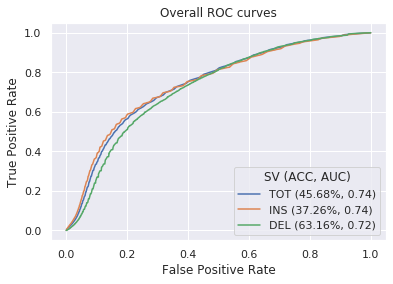

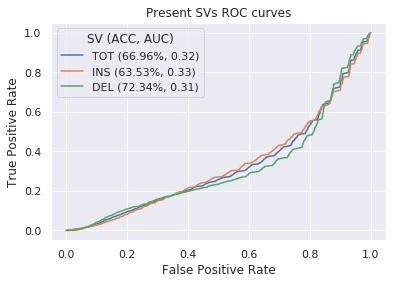

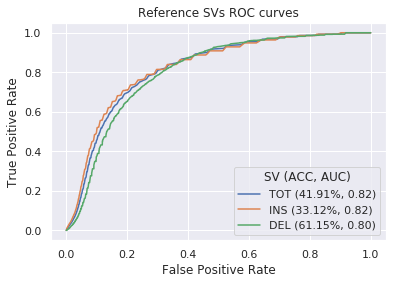

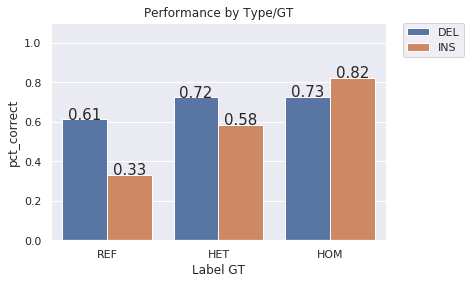

  svtype   GT  pct_correct
0    DEL  REF     0.611454
1    DEL  HET     0.722890
2    DEL  HOM     0.725209
3    INS  REF     0.331204
4    INS  HET     0.584260
5    INS  HOM     0.820782


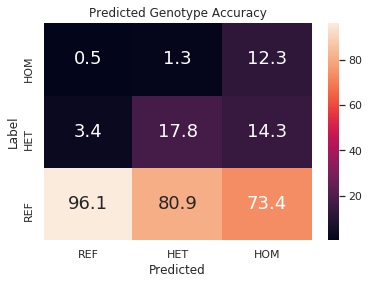

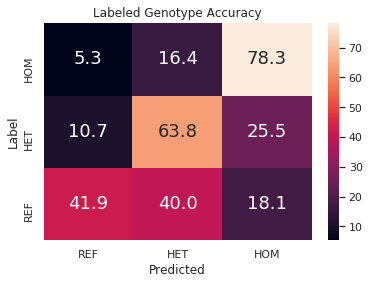

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV
0  0.904895  0.580895  0.783906  0.492145  0.419105  0.216094  0.961394


In [202]:
accuracy_report(p_results)

38827 SVs to report
Overall Accuracy: 0.8737218945579107
GT_label
0    0.877242
1    0.834134
2    0.916691
Name: concordant, dtype: float64


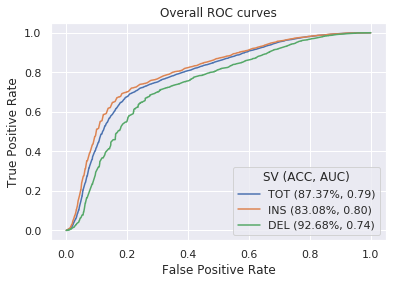

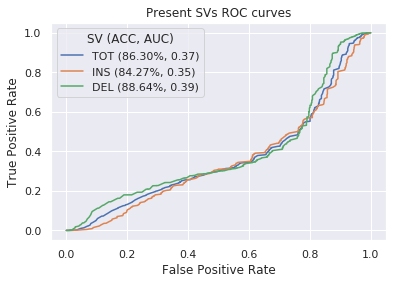

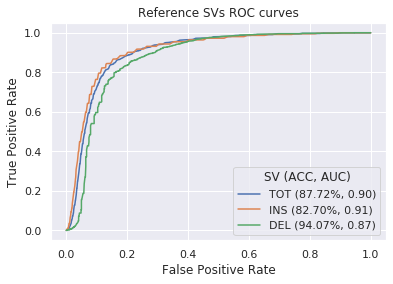

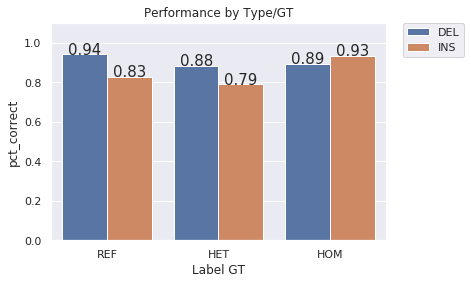

  svtype   GT  pct_correct
0    DEL  REF     0.940734
1    DEL  HET     0.883234
2    DEL  HOM     0.892931
3    INS  REF     0.826999
4    INS  HET     0.788580
5    INS  HOM     0.934874


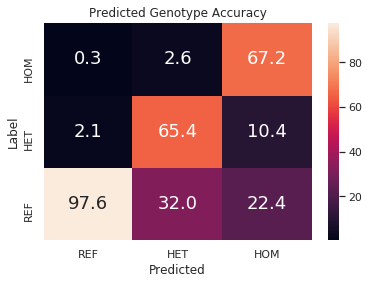

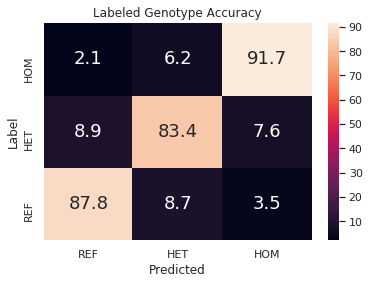

Presence Performance Overall
        TPR       FPR       FDR      ACC       TNR       PPV       NPV
0  0.934423  0.122758  0.285498  0.89139  0.877242  0.714502  0.976012


In [204]:
accuracy_report(p_results[p_results["NumNeighbors"] == 0])

In [175]:
presence_performance(par_test["presence"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.885146,0.54604,0.80781,0.509145,0.45396,0.19219,0.964197


In [176]:
presence_performance(par_test[par_test["NumNeighbors"] == 0]["presence"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.920765,0.111254,0.325113,0.895166,0.888746,0.674887,0.978128


In [177]:
presence_performance(results["presence"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.677934,0.111188,0.475413,0.856497,0.888812,0.524587,0.938459


In [178]:
presence_performance(results[results["NumNeighbors"] == 0]["presence"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV
0,0.915775,0.046374,0.143487,0.94484,0.953626,0.856513,0.973997


In [146]:
par_test["presence"].value_counts()

TP    13566
TN    13010
FN     3494
FP     3213
Name: presence, dtype: int64

In [147]:
results["presence"].value_counts()

TN    108971
TP     15042
FP     13632
FN      7146
Name: presence, dtype: int64

In [167]:
par_test.groupby(["GT_label", "predict"]).count()

GQ  concordant     DP  svtype    REF    HET    HOM  \
GT_label predict                                                          
0        0        75755       75755  75755   75755  75755  75755  75755   
         1        61204       61204  61204   61204  61204  61204  61204   
         2        29867       29867  29867   29867  29867  29867  29867   
         4           50          50     50      50     50     50     50   
1        0         2365        2365   2365    2365   2365   2365   2365   
         1        10638       10638  10638   10638  10638  10638  10638   
         2         4623        4623   4623    4623   4623   4623   4623   
         4           10          10     10      10     10     10     10   
2        0          448         448    448     448    448    448    448   
         1         1111        1111   1111    1111   1111   1111   1111   
         2         5283        5283   5283    5283   5283   5283   5283   
         4           14          14     14      14     14     14     14   

                  NumNeighbors  presence  
GT_label predict                          
0        0               75755      7837  
         1               61204      5471  
         2               29867      2839  
         4                  50         4  
1        0                2365      1583  
         1               10638      7799  
         2                4623      3068  
         4                  10         6  
2        0                 448       254  
         1                1111       615  
         2                5283      3798  
         4                  14         9

12357 SVs to report
Overall Accuracy: 0.8983572064416929
GT_label
0    0.991874
1    0.234783
2    0.423154
Name: concordant, dtype: float64


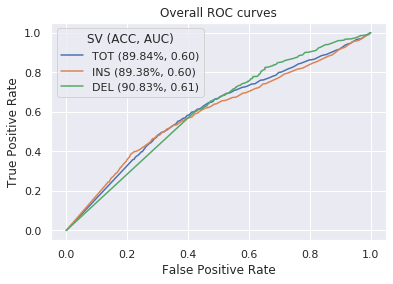

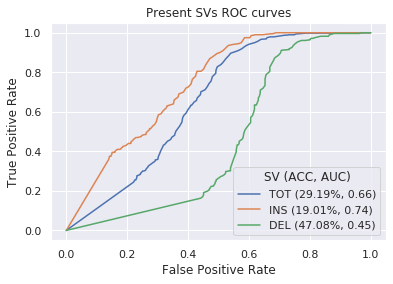

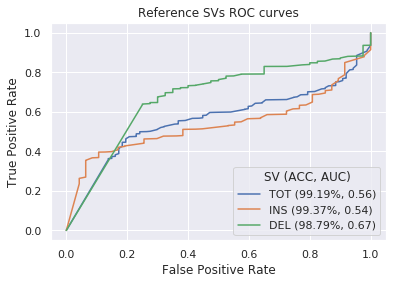

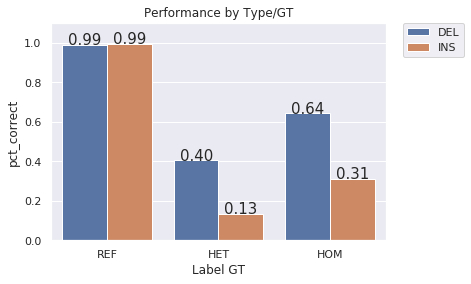

  svtype   GT  pct_correct
0    DEL  REF     0.987860
1    DEL  HET     0.403712
2    DEL  HOM     0.642857
3    INS  REF     0.993658
4    INS  HET     0.133519
5    INS  HOM     0.312312


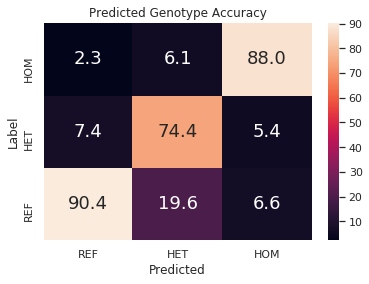

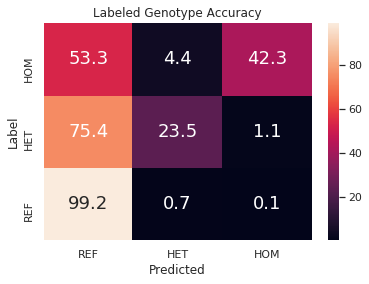

Presence Performance Overall
        TPR       FPR      FDR      ACC       TNR      PPV       NPV
0  0.313144  0.008126  0.14404  0.90119  0.991874  0.85596  0.903514
2979 SVs to report
Overall Accuracy: 0.9167505874454515
GT_label
0    0.986760
1    0.572368
2    0.666667
Name: concordant, dtype: float64


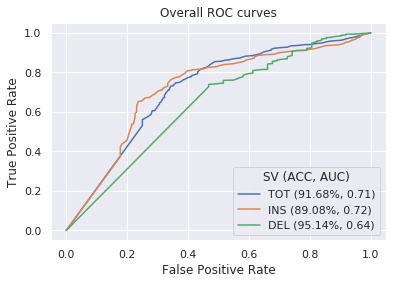

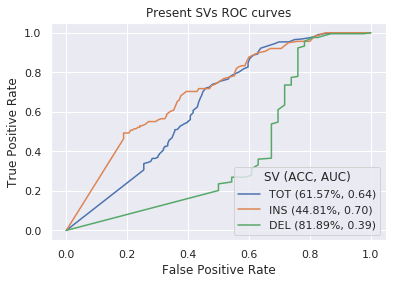

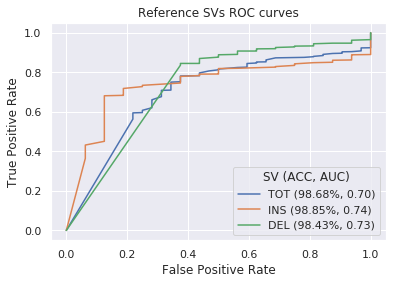

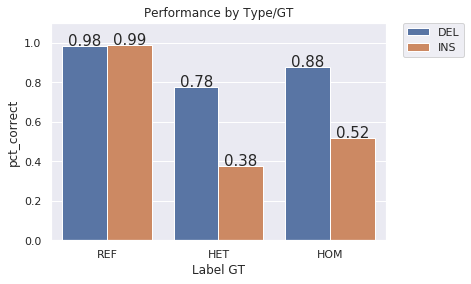

  svtype   GT  pct_correct
0    DEL  REF     0.984329
1    DEL  HET     0.777027
2    DEL  HOM     0.877358
3    INS  REF     0.988539
4    INS  HET     0.378205
5    INS  HOM     0.519737


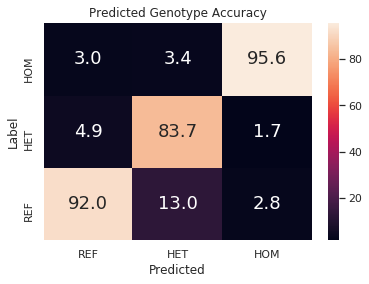

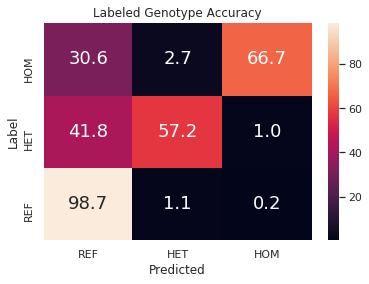

Presence Performance Overall
        TPR      FPR       FDR       ACC      TNR       PPV       NPV
0  0.633452  0.01324  0.082474  0.920107  0.98676  0.917526  0.920494


In [200]:
old_model_results, old_model_data = make_flatvcf_results("/home/english/science/english/gt_checks/results/HG00096.base.sv.jl",
                                                         "/home/english/science/english/gt_checks/results/HG00096.comp.sv.jl")
accuracy_report(old_model_results)
accuracy_report(old_model_results[old_model_results["NumNeighbors"] == 0])